# Figure 03. Representative Manhattan plots showing 19 of 40

susceptibility-associated regions identified with GWAS

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'ggh4x'

The following object is masked from 'package:ggplot2':

    guide_axis_logticks

In [ ]:
source(file.path("bin", "tox_colors.R"))
source(file.path("bin", "outs.R"))



Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

here() starts at /Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript

$strain_table
$strain_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.html"

$strain_table$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.tsv.zip"

$strain_table$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.docx"

$strain_table$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.csv"


$tox_table_ft
$tox_table_ft$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.html"

$tox_table_ft$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.tsv.zip"

$tox_table_ft$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.docx"

$tox_table_ft$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.csv"


$trait_table
$trait_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S3/table_S3.html"

$trait_table$tsv
[1] "

In [ ]:

# ==============================================================================#
# Manhattan Plot
# ==============================================================================#
# datPath = the path to an aggregate .tsv mapping file from NemaScan
# indepTestPath = the path to the independent tests for EIGEN threshold from NeamScan: Genotype_Matrix/total_independent_tests.txt
# xlab = ggplot x label default is: "Genomic position (Mb)"
# ylab = ggplot y label default is: expression(-log[10](italic(p)))
# title = Whatever you want to title the plot: default is: NULL
# sigThresh = The significance threshold to use for plotting, defualt is: NULL which shows BF and EIGEN,
#   other options are "BF" and "EIGEN" to show just one or the other.
# ==============================================================================#
manPlot <- function(dataPath,
                    indepTestPath,
                    xlab = "Genomic position (Mb)",
                    ylab = expression(-log[10](italic(p))),
                    title = NULL,
                    sigThresh = NULL) {
  # pull the nemascan data
  d.all <- data.table::fread(dataPath) %>%
    dplyr::distinct(marker, .keep_all = T)

  # filter out the mitochondria
  data <- d.all %>%
    dplyr::filter(CHROM != "MtDNA")


  # get the BF threshold
  BF <- -log10(0.05 / nrow(d.all %>% dplyr::distinct(marker)))

  # load independent tests result file to get EIGEN sig threshold
  total_independent_tests <- read.table(indepTestPath, quote = "\"", comment.char = "", stringsAsFactors = FALSE)
  EIGEN <- -log10(0.05 / total_independent_tests[[1]])

  # set sig thresholds
  if (is.null(sigThresh)) {
    sig.colors <- c("red", "#EE4266", "black")
    names(sig.colors) <- c("BF", "EIGEN", "NONSIG")
    # set the sig thresholds for plotting
    sig.df <- tibble::tibble(name = c("BF", "EIGEN"), sig = c(BF, EIGEN))
  } else {
    if (sigThresh == "BF") {
      sig.colors <- c("red", "black")
      names(sig.colors) <- c("BF", "NONSIG")
      sig.df <- tibble::tibble(name = "BF", sig = BF)
    }
    if (sigThresh == "EIGEN") {
      sig.colors <- c("red", "black")
      names(sig.colors) <- c("EIGEN", "NONSIG")
      sig.df <- tibble::tibble(name = "EIGEN", sig = EIGEN)
    }
    if (!is.null(sigThresh) & !(sigThresh %in% c("BF", "EIGEN"))) {
      message('Please specify a valid sigThresh: NULL, "BF", or "EIGEN"')
      stop()
    }
  }

  # add sig colors
  sig.data <- data %>%
    dplyr::mutate(sig = dplyr::case_when(
      log10p > BF ~ "BF",
      log10p > EIGEN & log10p <= BF ~ "EIGEN",
      TRUE ~ "NONSIG"
    ))
  # Plot it
  man.plot <- ggplot() +
    theme_bw() +
    geom_point(
      data = sig.data,
      mapping = aes(
        x = POS / 1000000,
        y = log10p,
        colour = sig,
        alpha = sig
      )
    ) +
    scale_alpha_manual(values = c("BF" = 1, "EIGEN" = 1, "user" = 1, "NONSIG" = 0.25)) +
    scale_colour_manual(values = sig.colors) +
    scale_x_continuous(expand = c(0, 0), breaks = c(5, 10, 15, 20)) +
    geom_hline(data = sig.df, aes(yintercept = sig, linetype = name)) +
    scale_linetype_manual(values = c("BF" = 1, "EIGEN" = 3, "user" = 2)) +
    labs(
      x = xlab,
      y = ylab
    ) + # expression(-log[10](italic(p)))
    theme(
      legend.position = "none",
      panel.grid = element_blank()
    ) +
    facet_grid(~CHROM, scales = "free")

  # add a title if needed
  if (is.null(title)) {
    return(man.plot)
  } else {
    man.plot2 <- man.plot +
      ggtitle(title)
    return(man.plot2)
  }
}


In [ ]:

# load them all
d.list <- NULL
for (i in 1:length(ex)) {
  # get the path
  p <- ex[[i]]
  # load the mapping file
  d <- data.table::fread(p)

  # get the name
  name <- names(ex[i])

  # add it to the list
  d.list[[name]] <- d
}

# bind it
d.all <- data.table::rbindlist(d.list) %>%
  dplyr::filter(CHROM != "MtDNA") %>%
  dplyr::distinct(trait, marker, .keep_all = T) %>%
  dplyr::left_join(tox)


Joining with `by = join_by(trait)`

Joining with `by = join_by(big_class)`

In [ ]:

manhattan_plots <- ggplot(d.all2) +
  theme_bw() +
  geom_rect(
    data = highlight_regions,
    aes(xmin = startPOS, xmax = endPOS, ymin = -Inf, ymax = Inf),
    fill = "yellow", alpha = 0.3
  ) +
  geom_point(
    data = d.all2,
    mapping = aes(
      x = POS / 1000000,
      y = log10p,
      colour = sig,
      alpha = sig
    ),
    size = 0.85
  ) +
  scale_alpha_manual(values = c("BF" = 1, "EIGEN" = 1, "user" = 1, "NONSIG" = 0.25)) +
  scale_colour_manual(values = sig.colors) +
  scale_x_continuous(expand = c(0, 0), breaks = c(5, 10, 15, 20)) +
  geom_hline(data = sig.df, aes(yintercept = sig, linetype = name), linewidth = 0.25) +
  scale_linetype_manual(values = c("BF" = 1, "EIGEN" = 3, "user" = 2)) +
  labs(
    x = "Genomic position (Mb)",
    y = expression(bold(-log[10](bolditalic(p))))
  ) +
  theme(
    legend.position = "none",
    panel.grid = element_blank()
  ) +
  ggh4x::facet_grid2(
    nice_drug_label2 ~ CHROM,
    scales = "free",
    strip = strip_y
  ) +
  theme(
    strip.background.x = ggplot2::element_rect(color = "black", fill = "white", linewidth = 0.5, linetype = "solid")
  )


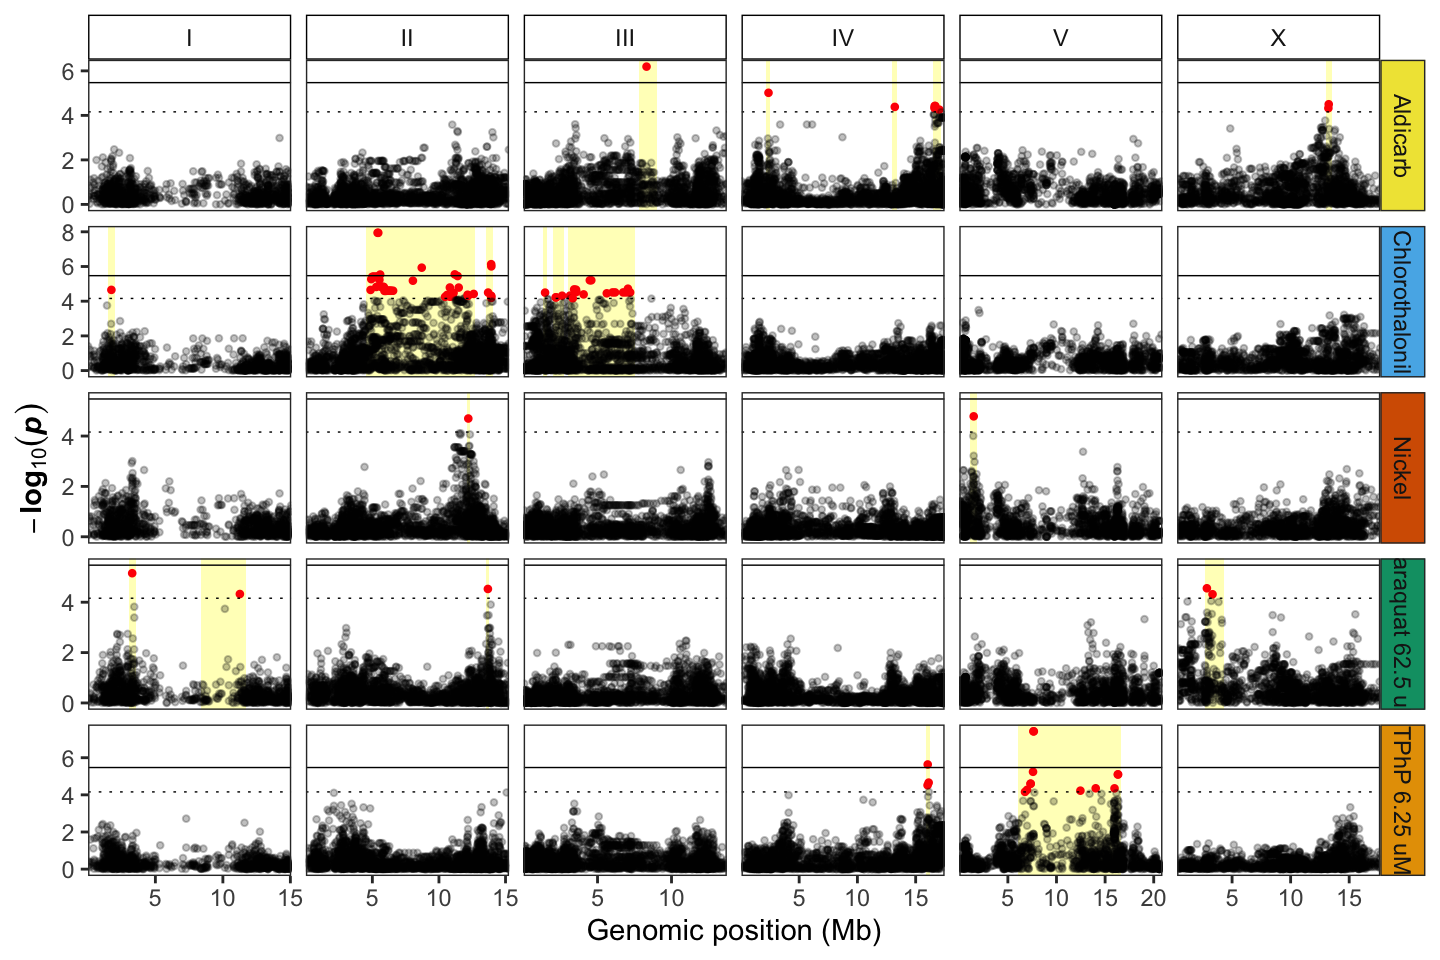

In [ ]:

manhattan_plots


Save the plot as a figure

In [ ]:
save_plot(
  manhattan_plots,
  figure_fns$manhattan_plots,
  w_in = 7.5,
  h_in = 5
)


Warning in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
semi-transparency is not supported on this device: reported only once per page